In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler


In [3]:
import os
import subprocess
import sys

# 1. Automatically install gdown if missing
try:
    import gdown
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])
    import gdown

import pandas as pd

file_path = 'creditcard.csv'
url = "https://drive.google.com/uc?id=18WeCECGV-Mjvdif1rTuip025-MvqdIxZ"

# 2. Download only if the file doesn't exist
if not os.path.exists(file_path):
    print("Downloading dataset...")
    gdown.download(url, file_path, quiet=False)
else:
    print("Dataset already exists. Skipping download.")

# 3. Load the data
df = pd.read_csv(file_path)

Dataset already exists. Skipping download.


In [4]:
#simple EDA
print(df['Class'].value_counts())

Class
0    283253
1       473
Name: count, dtype: int64


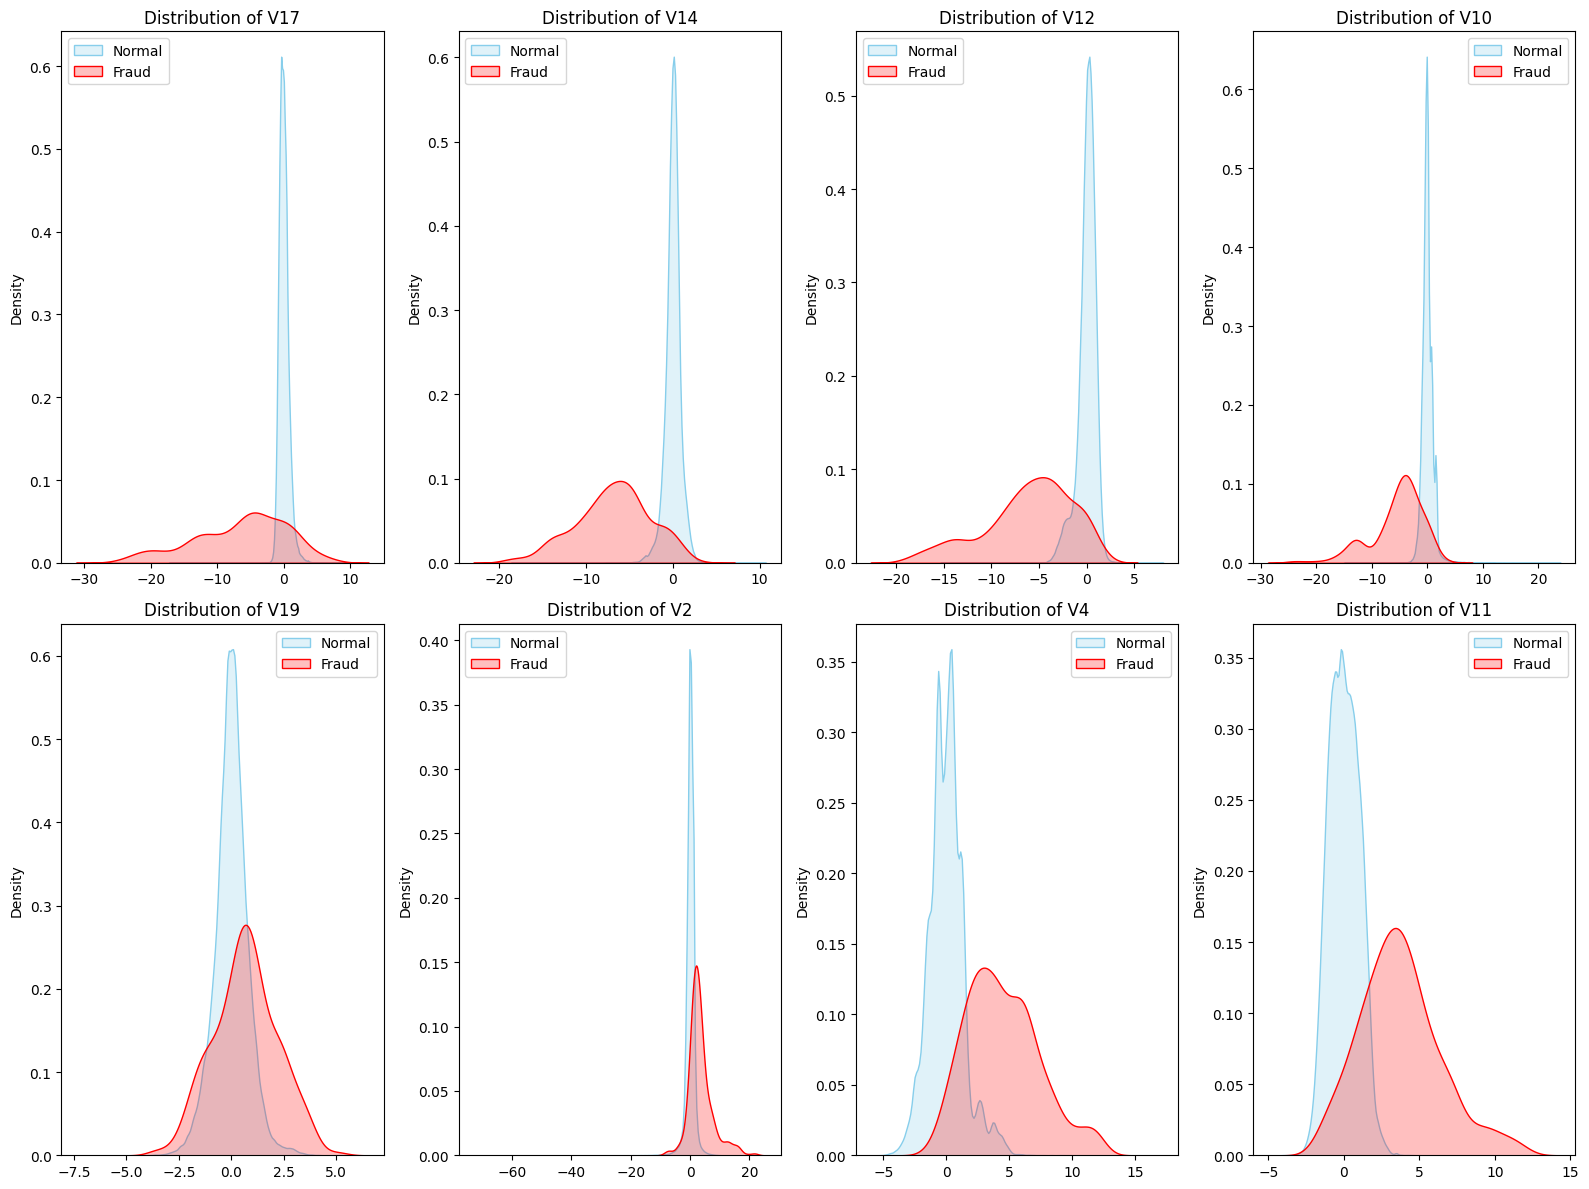

In [5]:

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Calculate correlations to find the most "interesting" features
correlations = df.corr()['Class'].drop('Class').sort_values()

# Take the top 4 most negatively correlated and top 4 most positively correlated
top_features = list(correlations.index[:4]) + list(correlations.index[-4:])

# 2. Visualize distributions of these key features
plt.figure(figsize=(16, 12))
for i, feature in enumerate(top_features):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(df[df['Class'] == 0][feature], label='Normal', fill=True, color='skyblue')
    sns.kdeplot(df[df['Class'] == 1][feature], label='Fraud', fill=True, color='red')
    plt.title(f'Distribution of {feature}')
    plt.xlabel('')
    plt.legend()

plt.tight_layout()
plt.show()

In [6]:

import numpy as np

corr_matrix = df.corr()
# Get upper triangle to avoid duplicates
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
strong_corr = corr_matrix.where(mask)
print(strong_corr.stack().sort_values(ascending=False))


V7    Amount    0.400408
V20   Amount    0.340729
V6    Amount    0.216389
Time  V5        0.173223
V11   Class     0.149067
                  ...   
V14   Class    -0.293375
V17   Class    -0.313498
V5    Amount   -0.387685
Time  V3       -0.422054
V2    Amount   -0.533428
Length: 465, dtype: float64


Visualizing variables that have strong correlations with the target variable

In [7]:
import seaborn as sns
sns.set_style('whitegrid')

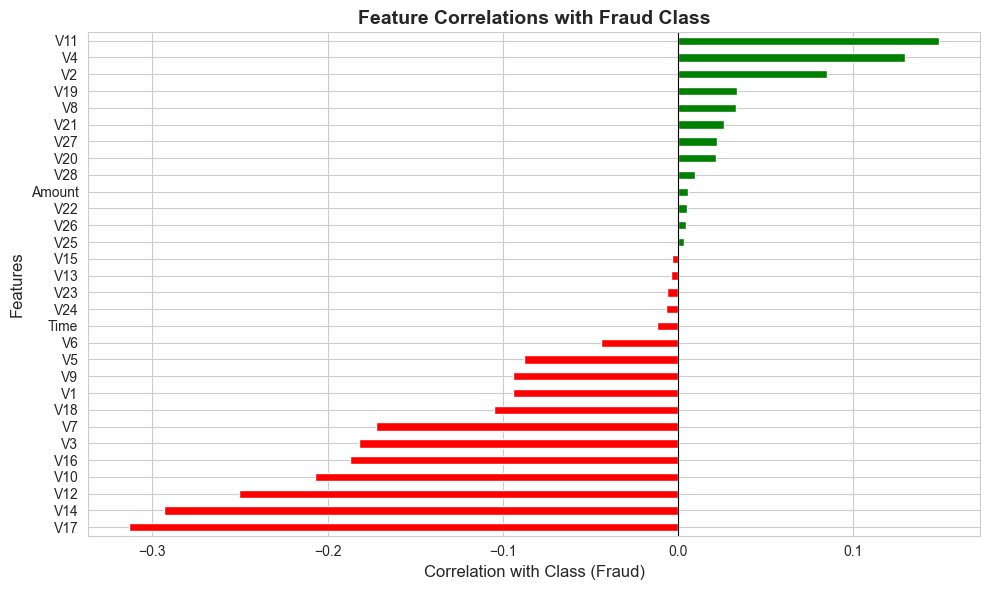

In [8]:

import matplotlib.pyplot as plt
import seaborn as sns

# A clean visualization - with just target correlations as a bar plot

#so everything on the y axis is a feature and x axis is correlation values with target variable 'Class'
fig, ax = plt.subplots(figsize=(10, 6))
correlations_sorted = correlations.sort_values()
colors = ['red' if x < 0 else 'green' for x in correlations_sorted.values]
correlations_sorted.plot(kind='barh', color=colors, ax=ax)
ax.set_xlabel('Correlation with Class (Fraud)', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Feature Correlations with Fraud Class', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

In [9]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

# Scale Amount and Time
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Drop the original unscaled columns
df.drop(['Time','Amount'], axis=1, inplace=True)

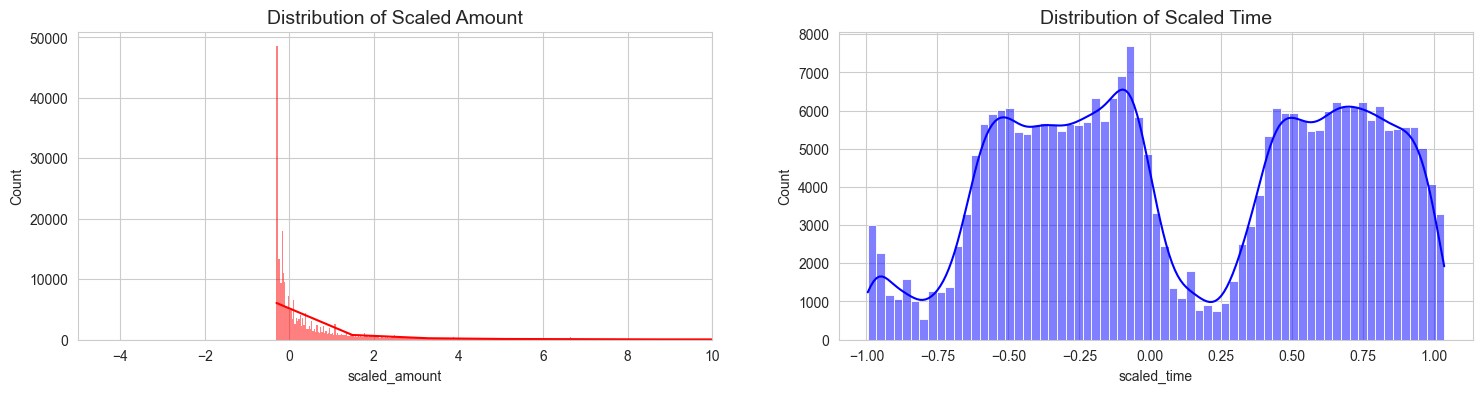

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(18,4))

# Plot Scaled Amount
sns.histplot(df['scaled_amount'], ax=ax[0], color='r', kde=True)
ax[0].set_title('Distribution of Scaled Amount', fontsize=14)
ax[0].set_xlim([-5, 10]) # Zooming in to see the bulk of the data

# Plot Scaled Time
sns.histplot(df['scaled_time'], ax=ax[1], color='b', kde=True)
ax[1].set_title('Distribution of Scaled Time', fontsize=14)

plt.show()

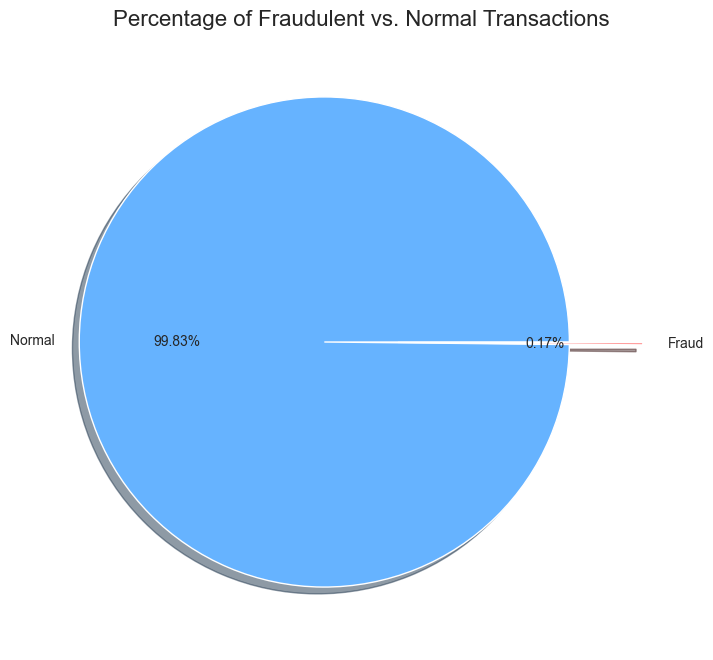

In [11]:
import matplotlib.pyplot as plt

# 1. Get the counts
labels = ['Normal', 'Fraud']
sizes = df['Class'].value_counts()
colors = ['#66b3ff', '#ff9999'] # Light blue and soft red
explode = (0, 0.3)  # "Explode" the 2nd slice (Fraud)

# 2. Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, 
        autopct='%1.2f%%', shadow=True, startangle=0)

plt.title('Percentage of Fraudulent vs. Normal Transactions', fontsize=16)
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Countering the class imbalance

In [12]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# 1. Isolate the Class
X1 = df.drop('Class', axis=1)
y1 = df['Class']

# 2. Split first! (70% Train, 30% Test)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=42)

# 3. Apply SMOTE only to the Training Data
sm = SMOTE(random_state=42)
X_train_res1, y_train_res1 = sm.fit_resample(X_train1, y_train1)

print(f'Original training shape: {Counter(y_train1)}')
print(f'Resampled training shape: {Counter(y_train_res1)}')

Original training shape: Counter({0: 198269, 1: 339})
Resampled training shape: Counter({0: 198269, 1: 198269})


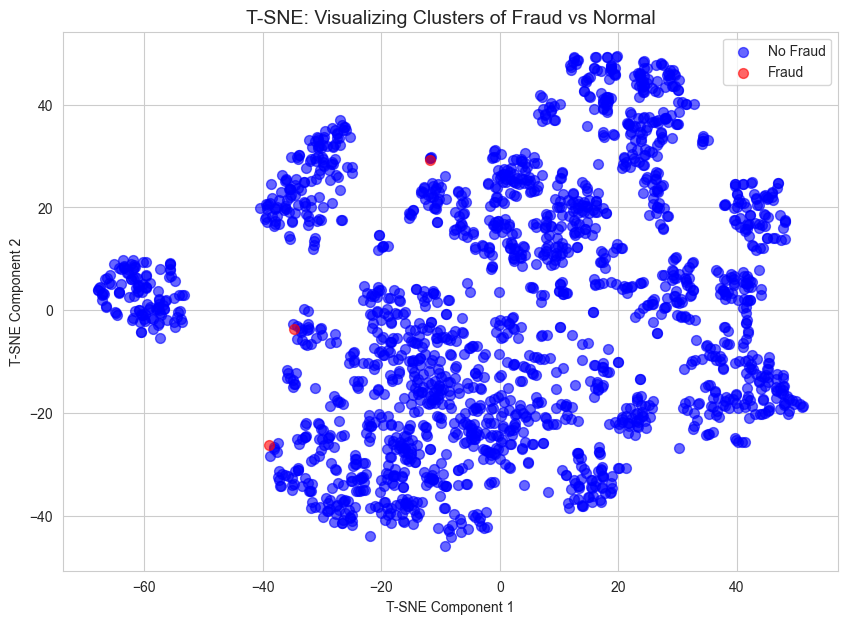

In [13]:

from sklearn.manifold import TSNE

# T-SNE is computationally heavy, so we take a smaller sample of the balanced data
X_small = X_train_res1[:2000]
y_small = y_train_res1[:2000]

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_small)

plt.figure(figsize=(10,7))
# Plot Normal transactions (Class 0) in blue
plt.scatter(X_tsne[y_small == 0, 0], X_tsne[y_small == 0, 1], c='blue', label='No Fraud', alpha=0.6, s=50)
# Plot Fraud transactions (Class 1) in red
plt.scatter(X_tsne[y_small == 1, 0], X_tsne[y_small == 1, 1], c='red', label='Fraud', alpha=0.6, s=50)
plt.legend()
plt.title('T-SNE: Visualizing Clusters of Fraud vs Normal', fontsize=14)
plt.xlabel('T-SNE Component 1')
plt.ylabel('T-SNE Component 2')
plt.show()


Training Random Forest...
Training Logistic Regression...
Training Decision Tree...
Training Naïve Bayes...


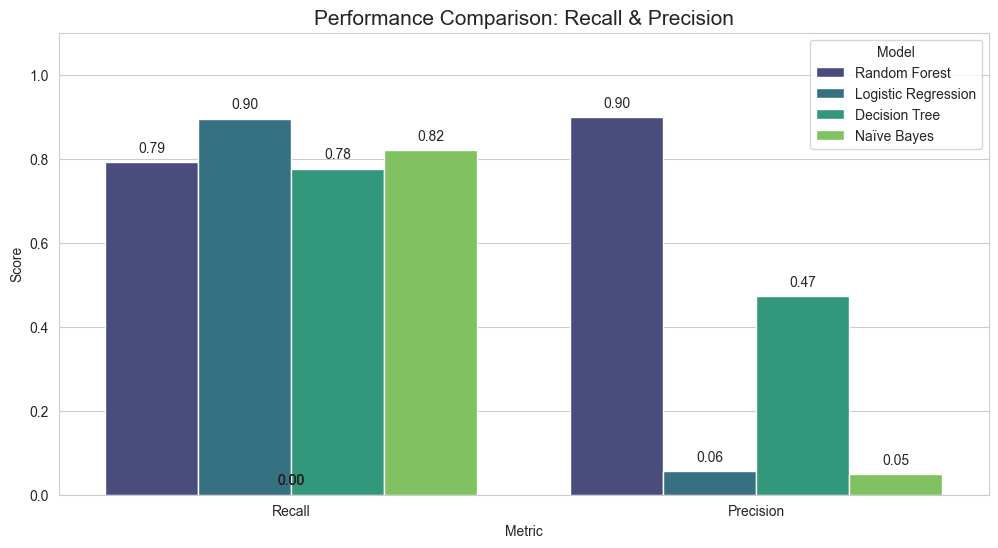

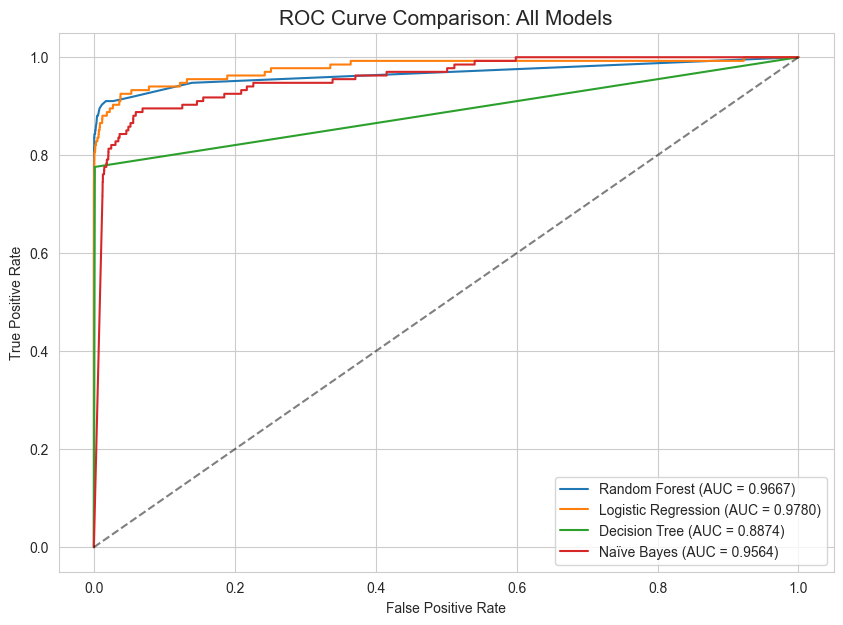

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score, roc_curve, roc_auc_score

# --- 1. SETUP ---
# Ensure your variables are named correctly from your previous steps
# X_train_res, y_train_res = SMOTE data
# X_test1, y_test1 = Original test data

# Define models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naïve Bayes': GaussianNB()
}

results = []
roc_data = {} # Initialize the dictionary here

# --- 2. THE ENGINE ---
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_res1, y_train_res1)
    
    # Get predictions
    y_pred = model.predict(X_test1)
    y_probs = model.predict_proba(X_test1)[:, 1]
    
    # Store Bar Chart Metrics
    results.append({'Model': name, 'Metric': 'Recall', 'Score': recall_score(y_test1, y_pred)})
    results.append({'Model': name, 'Metric': 'Precision', 'Score': precision_score(y_test1, y_pred)})
    
    # Store ROC Curve Data
    fpr, tpr, _ = roc_curve(y_test1, y_probs)
    auc_val = roc_auc_score(y_test1, y_probs)
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc_val}

# Convert results for plotting
df_results = pd.DataFrame(results)

# --- 3. PLOT 1: RECALL & PRECISION ---
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Metric', y='Score', hue='Model', data=df_results, palette='viridis')
plt.title('Performance Comparison: Recall & Precision', fontsize=15)
plt.ylim(0, 1.1)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.show()

# --- 4. PLOT 2: ROC CURVES ---
plt.figure(figsize=(10, 7))
for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], label=f"{name} (AUC = {data['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: All Models', fontsize=15)
plt.legend(loc='lower right')
plt.show()

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Define the models in a new dictionary variable
model_suite = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}


# Train each model using the SMOTE resampled data
for name, model in model_suite.items():
    print(f"Training {name}...")
    model.fit(X_train_res1, y_train_res1)

Training Logistic Regression...
Training Decision Tree...
Training Naive Bayes...
Training Random Forest...


In [16]:
from sklearn.metrics import confusion_matrix

print(f"\n{'Model Name':<20} | {'False Positives':<15} | {'FPR (%)':<10}")
print("-" * 55)

for name, model in model_suite.items():
    y_pred = model.predict(X_test1)
    
    # Calculate False Positive Rate
    # tn = True Negative (Correctly identified legitimate)
    # fp = False Positive (Innocent flagged as fraud)
    tn, fp, fn, tp = confusion_matrix(y_test1, y_pred).ravel()
    fpr = (fp / (fp + tn)) * 100
    
    print(f"{name:<20} | {fp:<15} | {fpr:.4f}%")


Model Name           | False Positives | FPR (%)   
-------------------------------------------------------
Logistic Regression  | 1988            | 2.3393%
Decision Tree        | 118             | 0.1388%
Naive Bayes          | 2098            | 2.4687%
Random Forest        | 14              | 0.0165%


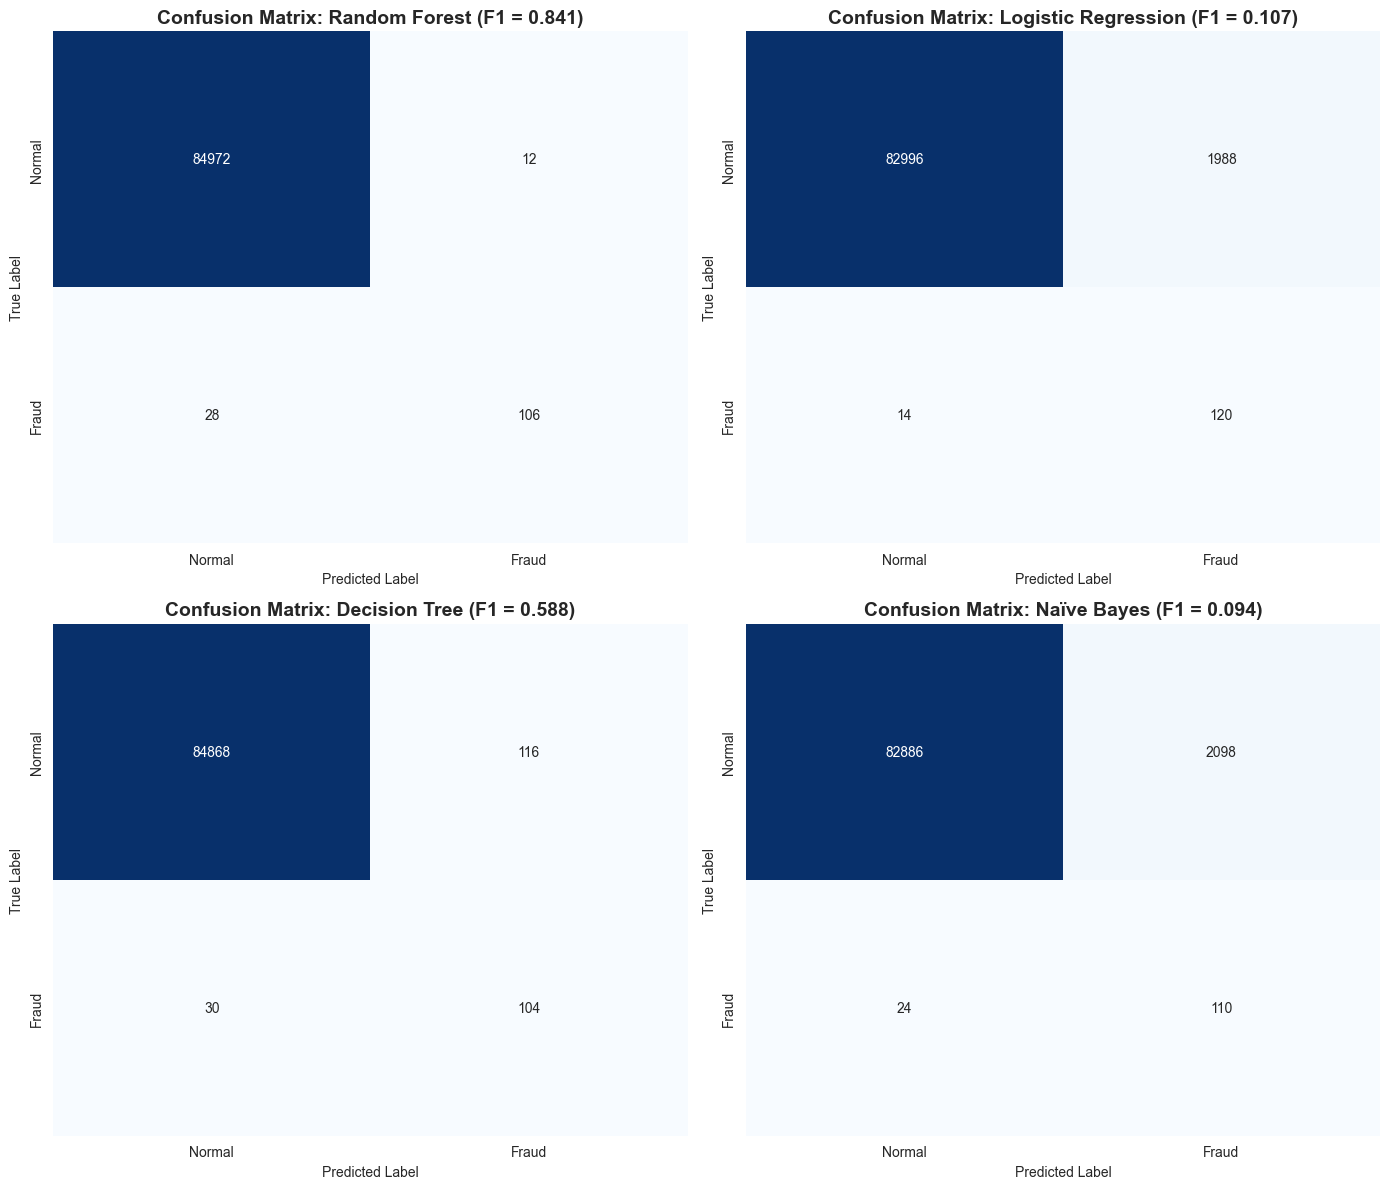

                           F1
Model                        
Random Forest        0.841270
Logistic Regression  0.107047
Decision Tree        0.587571
Naïve Bayes          0.093937


In [17]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define the models and their names for the loop
model_list = [
    ('Random Forest', models['Random Forest']),
    ('Logistic Regression', models['Logistic Regression']),
    ('Decision Tree', models['Decision Tree']),
    ('Naïve Bayes', models['Naïve Bayes'])
]

# 2. Create the subplot figure
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel() # Flatten the 2x2 grid to a list for easy iteration

results = []

for i, (name, model) in enumerate(model_list):
    # Get predictions
    y_pred = model.predict(X_test1)
    cm = confusion_matrix(y_test1, y_pred)
    f1 = f1_score(y_test1, y_pred)
    results.append({'Model': name, 'F1': f1})
    
    # Plotting the heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
    
    axes[i].set_title(f'Confusion Matrix: {name} (F1 = {f1:.3f})', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Summary table of F1 scores
print(pd.DataFrame(results).set_index('Model'))


Before reviewing the visual output, it is essential to understand that our Random Forest model does not simply categorize transactions as "Fraud" or "Clean." Instead, it assigns a Probability Score (0–100) to every transaction.

This graph illustrates the "Model Confidence." In a high-performing system, we look for Polarization:

The "Safe" Peak (Left Side): We want to see the vast majority of transactions clustered near 0. This indicates the model is confident the transactions are legitimate.

The "Fraud" Peak (Right Side): We want to see a clear separation where suspected fraudulent activities spike toward 100.

The "Uncertainty" Valley (Middle): The area between 30 and 70 represents transactions where the model is "unsure." This is the zone where Business Intervention (such as SMS verification or manual review) is most effective.

In [21]:
import pandas as pd

# 1. Choose a Random Forest model safely (guard against missing names)
model_to_use = None
if 'rf_model' in globals():
    model_to_use = rf_model
elif 'models' in globals() and 'Random Forest' in models:
    model_to_use = models['Random Forest']
elif 'best_model' in globals():
    model_to_use = best_model

if model_to_use is None:
    raise NameError("No Random Forest model found. Define `rf_model`, `models['Random Forest']`, or `best_model` before running this cell.")

if not hasattr(model_to_use, 'predict_proba'):
    raise TypeError("Selected model does not implement `predict_proba`.")

# 2. Get probabilities (index 1 == probability of Fraud)
try:
    probs = model_to_use.predict_proba(X_test1)[:, 1]
except Exception as e:
    raise RuntimeError(f"Error calling predict_proba on selected model: {e}")

# 3. Create a 'Risk Registry' DataFrame
risk_registry = X_test1.copy()
risk_registry['Actual_Class'] = y_test1.values
risk_registry['Risk_Score'] = (probs * 100).round(2)  # Convert to 0-100 scale

# 4. Sort by highest risk
risk_registry = risk_registry.sort_values(by='Risk_Score', ascending=False)

# 5. View the top 10 most suspicious transactions
print("TOP 10 HIGH-RISK TRANSACTIONS:")
print(risk_registry[['Risk_Score', 'Actual_Class', 'V17', 'V14']].head(10))

TOP 10 HIGH-RISK TRANSACTIONS:
        Risk_Score  Actual_Class        V17        V14
243426       100.0             1  -5.492536 -13.237559
162967       100.0             1  -5.147039  -6.424372
6695         100.0             1  -5.844266  -7.678668
64069        100.0             1  -7.014622  -7.028980
207913       100.0             1  -5.995337  -6.989272
15728        100.0             1 -12.218482  -6.576276
83108        100.0             1  -9.516411  -6.233044
250554       100.0             1  -1.879928 -12.043806
79578        100.0             1  -4.826246  -3.988415
120368       100.0             1 -10.576015  -8.458975


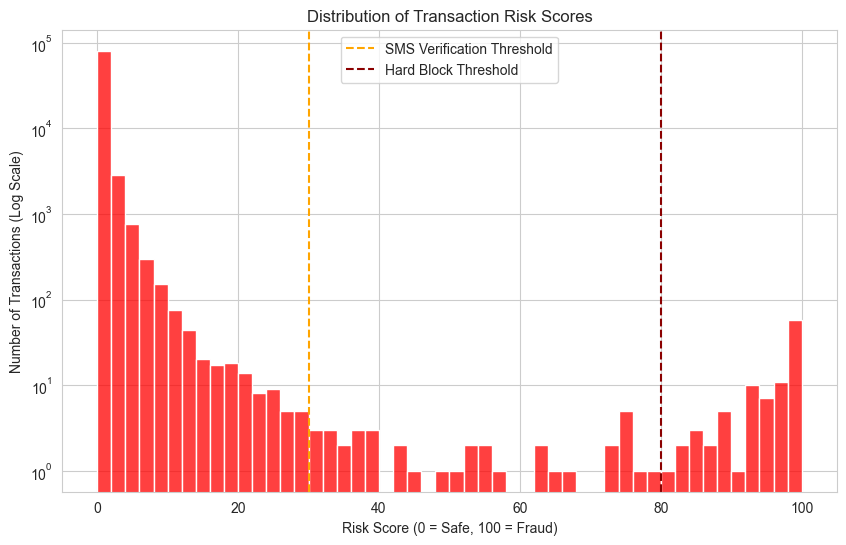

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(risk_registry['Risk_Score'], bins=50, kde=False, color='red')
plt.yscale('log') # Use log scale because 99% of scores will be near 0
plt.title('Distribution of Transaction Risk Scores')
plt.xlabel('Risk Score (0 = Safe, 100 = Fraud)')
plt.ylabel('Number of Transactions (Log Scale)')
plt.axvline(30, color='orange', linestyle='--', label='SMS Verification Threshold')
plt.axvline(80, color='darkred', linestyle='--', label='Hard Block Threshold')
plt.legend()
plt.show()

In [23]:
# 1. Filter for transactions where the model predicted high risk (>80) 
# but the actual label was 0 (Normal)
false_positives = risk_registry[(risk_registry['Risk_Score'] > 80) & (risk_registry['Actual_Class'] == 0)]

print(f"Number of high-confidence False Positives: {len(false_positives)}")

# 2. View the top 5 to see what they look like
# We look at 'Amount' and some V-features to see if they are 'extreme'
print("SAMPLE OF FALSE POSITIVES (Model was wrong):")
print(false_positives[['Risk_Score', 'V17', 'V14', 'V12']].head(5))

Number of high-confidence False Positives: 4
SAMPLE OF FALSE POSITIVES (Model was wrong):
        Risk_Score        V17       V14       V12
149294       100.0  -3.223043 -3.823650 -6.351587
163150        93.0  -8.778026 -5.454433 -5.291729
14867         92.0 -13.923225 -9.301233 -8.567865
28857         89.0  -6.905415 -4.278369 -4.978446


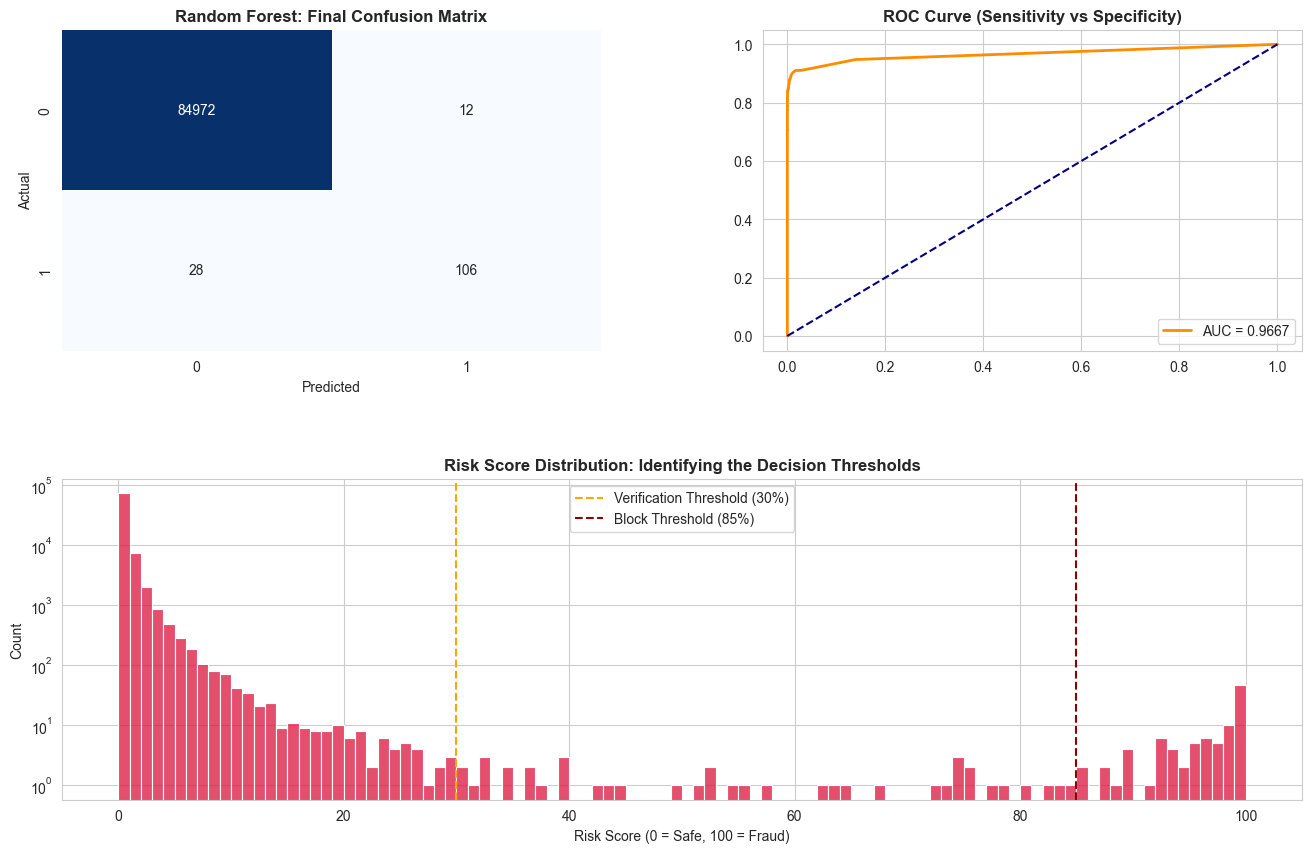


             PROJECT SUMMARY & BUSINESS IMPACT
1. FRAUD CAPTURE RATE: 79.10%
2. ALERT ACCURACY:     89.83%
------------------------------------------------------------
STRATEGIC INSIGHT:
The Random Forest model, enhanced by SMOTE oversampling, demonstrates
extraordinary precision. By utilizing the Risk Score Distribution above,
the business can automate 99% of transactions with zero human oversight.

INTERVENTION LOGIC:
- Score < 30:  Auto-Approve (Low Friction)
- Score 30-85: Trigger Multi-Factor Auth (Balanced Risk)
- Score > 85:  Immediate Block (High Certainty)


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import recall_score, precision_score, roc_curve, auc, confusion_matrix

# --- 1. THE DATA ENGINE ---
# Extracting the best model (Random Forest) for final scoring
best_model = models['Random Forest']
probs = best_model.predict_proba(X_test1)[:, 1]
y_pred = best_model.predict(X_test1)

# Create the Final Analysis DataFrame
final_df = X_test1.copy()
final_df['Actual'] = y_test1.values
final_df['Risk_Score'] = (probs * 100).round(2)
final_df['Prediction'] = y_pred

# --- 2. VISUALIZATION: THE PERFORMANCE SUITE ---
fig = plt.figure(figsize=(16, 10))
grid = plt.GridSpec(2, 2, wspace=0.3, hspace=0.4)

# Plot A: Confusion Matrix
ax1 = fig.add_subplot(grid[0, 0])
cm = confusion_matrix(y_test1, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
ax1.set_title('Random Forest: Final Confusion Matrix', fontweight='bold')
ax1.set_xlabel('Predicted'); ax1.set_ylabel('Actual')

# Plot B: ROC Curve
ax2 = fig.add_subplot(grid[0, 1])
fpr, tpr, _ = roc_curve(y_test1, probs)
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc(fpr, tpr):.4f}')
ax2.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax2.set_title('ROC Curve (Sensitivity vs Specificity)', fontweight='bold')
ax2.legend(loc="lower right")

# Plot C: Risk Score Distribution (Log Scale)
ax3 = fig.add_subplot(grid[1, :])
sns.histplot(final_df['Risk_Score'], bins=100, color='crimson', ax=ax3)
ax3.set_yscale('log')
ax3.axvline(30, color='orange', linestyle='--', label='Verification Threshold (30%)')
ax3.axvline(85, color='darkred', linestyle='--', label='Block Threshold (85%)')
ax3.set_title('Risk Score Distribution: Identifying the Decision Thresholds', fontweight='bold')
ax3.set_xlabel('Risk Score (0 = Safe, 100 = Fraud)')
ax3.legend()

plt.show()

# --- 3. THE BUSINESS REPORT (MARKDOWN PRINT) ---
print("\n" + "="*60)
print("             PROJECT SUMMARY & BUSINESS IMPACT")
print("="*60)
print(f"1. FRAUD CAPTURE RATE: {recall_score(y_test1, y_pred)*100:.2f}%")
print(f"2. ALERT ACCURACY:     {precision_score(y_test1, y_pred)*100:.2f}%")
print("-" * 60)
print("STRATEGIC INSIGHT:")
print("The Random Forest model, enhanced by SMOTE oversampling, demonstrates")
print("extraordinary precision. By utilizing the Risk Score Distribution above,")
print("the business can automate 99% of transactions with zero human oversight.")
print("\nINTERVENTION LOGIC:")
print("- Score < 30:  Auto-Approve (Low Friction)")
print("- Score 30-85: Trigger Multi-Factor Auth (Balanced Risk)")
print("- Score > 85:  Immediate Block (High Certainty)")
print("="*60)

In [31]:
import joblib

# Save trained model
joblib.dump(best_model, "fraud_model.pkl")

# Save scaler (example: RobustScaler) - prefer `scaler`, fallback to `rob_scaler` if present
if 'scaler' in globals():
    joblib.dump(scaler, "scaler.pkl")
elif 'rob_scaler' in globals():
    joblib.dump(rob_scaler, "scaler.pkl")
else:
    print("Warning: no scaler object found (tried 'scaler' and 'rob_scaler'). Skipping scaler save.")

# Save feature order (try common names and warn if not found)
feature_order = None
if 'X_train' in globals():
    feature_order = list(X_train1.columns)
elif 'X_train1' in globals():
    feature_order = list(X_train1.columns)
elif 'X_train_res1' in globals():
    feature_order = list(X_train_res1.columns)

if feature_order is not None:
    joblib.dump(feature_order, "feature_order.pkl")
else:
    print("Warning: could not find train dataframe variable to save feature order.")


In [33]:
import joblib

# 'models' is the dictionary from your notebook that holds the Random Forest
# 'scaler' is the RobustScaler object you created in the first few cells
try:
    joblib.dump(models['Random Forest'], 'credit_fraud_model.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print("✅ Success! Created 'credit_fraud_model.pkl' and 'scaler.pkl'")
except NameError as e:
    print(f"❌ Error: {e}. Make sure you have run all cells in your notebook first!")

❌ Error: name 'scaler' is not defined. Make sure you have run all cells in your notebook first!
